### **PART III: Compare Flood Extent to FEMA Flood Zones**

#### Step 1: Set up 

In [6]:
# Import packages
import os
import rasterio as rio
from rasterio.plot import show
#import rioxarray as rxr
import geopandas as gpd
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # for rectangle in tracts fig

In [7]:
# check directory
os.getcwd()

'c:\\Users\\rcompos\\OneDrive - North Carolina State University\\Documents\\Research\\Scripts\\Scripts_use_floods_take_2_bb'

In [10]:
# Paths 
#ida_vector_path = 'data\\ida_extent_1.04.24_vec.geojson' # flood extent converted from tif to shapefile in QGIS
ida_vector_path = "\\ida_vector_06.23clip\\ida_vec_clip_06.23.24.shp"
fema_zones_path = 'data\\all_sa_fema_zones_v2.shp'
counties_path = "data\\study_area_v1.shp"
tracts_path = "data\\SVI2020_PA_Tract.geojson"
study_area_path = "data\\study_area_dissolved.shp"

In [11]:
# read in files
extent = gpd.read_file(ida_vector_path) # flood extent
zones = gpd.read_file(fema_zones_path) # fema flood zones
counties = gpd.read_file(counties_path)
tracts = gpd.read_file(tracts_path)
study_area = gpd.read_file(study_area_path) # for tracts figure

In [12]:
# Match all projections
# units are feet
counties = counties.to_crs('6565')
zones = zones.to_crs('6565')
extent = extent.to_crs('6565')
tracts = tracts.to_crs('6565')
sa = study_area.to_crs('6565')

print(f'Check that extent crs: {extent.crs}\n',
      f'and zones crs match {zones.crs}\n',
      f'and the counties crs: {counties.crs}')

Check that extent crs: EPSG:6565
 and zones crs match EPSG:6565
 and the counties crs: EPSG:6565


### Step 2: Prepare Data

In [13]:
# prep data
cnties = counties[['geometry','COUNTY']]
ex = extent[(extent['Class']==2) | (extent['Class']==1)]
zo = zones[['geometry','COUNTY','ZONE_S']]
#zo100 = zo[(zo['ZONE_S']=='100_yr')]

In [14]:
# reclassify FEMA zones into something simpler
def label_zone(row):
   if row['ZONE_S'] == '100_yr':
      return '100_yr'
   if row['ZONE_S'] == '500_yr':
      return '500_yr'
   if row['ZONE_S'] =='min_haz':
      return 'min_haz'
   return 'other'

zo['ZONE_SS'] = zo.apply(label_zone, axis=1)

c:\Users\rcompos\Anaconda3\envs\NR491\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
# dissolve zones to simplify clip
zo_d100 = zo[zo['ZONE_SS']=='100_yr'].dissolve(['COUNTY'])
zo_d500 = zo[zo['ZONE_SS']=='500_yr'].dissolve(['COUNTY'])
zo_dmin = zo[zo['ZONE_SS']=='min_haz'].dissolve(['COUNTY'])
zo_dot = zo[zo['ZONE_SS']=='other'].dissolve(['COUNTY'])
zo_d100

,geometry,ZONE_S,ZONE_SS
COUNTY,,,
Bucks,"MULTIPOLYGON (((2637232.921 376119.298, 263723...",100_yr,100_yr
Delaware,"MULTIPOLYGON (((2591543.553 193126.774, 259154...",100_yr,100_yr
Montgomery,"MULTIPOLYGON (((2570547.834 333951.713, 257049...",100_yr,100_yr
Philadelphia,"MULTIPOLYGON (((2673036.026 209299.831, 267303...",100_yr,100_yr


In [16]:
# join counties to flood extent
ex_c =  ex.sjoin(cnties,how='inner', predicate='intersects')
ex_d1 = ex_c[ex_c['Class']==1].dissolve(['COUNTY'])
ex_d2 = ex_c[ex_c['Class']==2].dissolve(['COUNTY'])
ex_d2

,geometry,fid,Class,index_right
COUNTY,,,,
Bucks,"MULTIPOLYGON (((2640727.095 375802.494, 264075...",2.0,2,0
Delaware,"MULTIPOLYGON (((2573596.851 191043.820, 257359...",19713.0,2,1
Montgomery,"MULTIPOLYGON (((2544102.585 335643.533, 254410...",4786.0,2,2
Philadelphia,"MULTIPOLYGON (((2668432.912 208238.805, 266840...",17530.0,2,3


### Step 3: Clip floods to FEMA zones by county & calculate area

In [17]:
# clip to get flood extent in diff fema zones
flo_100 = ex_d2.clip(zo_d100)
flo_500 = ex_d2.clip(zo_d500)
flo_min = ex_d2.clip(zo_dmin)
flo_ot = ex_d2.clip(zo_dot)

In [18]:
# calculate area of flood in different zones
flo_100['area_100_fz'] = flo_100.area
flo_500['area_500_fz'] = flo_500.area
flo_min['area_min_fz'] = flo_min.area
flo_ot['area_ot_fz'] = flo_ot.area
flo_100.head()

flo_100.reset_index(inplace=True)
flo_500.reset_index(inplace=True)
flo_min.reset_index(inplace=True)
flo_ot.reset_index(inplace=True)

In [19]:
# combine all flood areas in counties
d1 = flo_100[['COUNTY','area_100_fz']]
d2 = flo_500[['COUNTY','area_500_fz']]
d3 = flo_min[['COUNTY','area_min_fz']]
d4 = flo_ot[['COUNTY','area_ot_fz']]
flood_table = d1.merge(d2,on='COUNTY').merge(d3,on='COUNTY').merge(d4,on='COUNTY')
flood_table


,COUNTY,area_100_fz,area_500_fz,area_min_fz,area_ot_fz
0,Delaware,5.270202e+06,1.215294e+05,7.607087e+05,2.872604e+06
1,Philadelphia,9.105480e+06,9.016357e+04,7.283387e+05,7.854706e+06
2,Montgomery,1.972092e+07,8.390117e+05,3.220845e+06,2.216532e+07
3,Bucks,2.258179e+07,1.823241e+06,1.426155e+07,2.583770e+07


In [20]:
# make general areas
ex_d1['area_wat'] = ex_d1.area # get wat area per cnty
ex_d2['area_fl'] = ex_d2.area # get flood area per cnty
cnties['area_c'] = cnties.area # get area of each cnty
zo_d100['area_100'] = zo_d100.area # get area of 100yr flood zone per cnty
zo_d500['area_500'] = zo_d500.area 
zo_dmin['area_min'] = zo_dmin.area 
zo_dot['area_ot'] = zo_dot.area 

# reset index
ex_d1.reset_index(inplace=True)
ex_d2.reset_index(inplace=True)
cnties.reset_index(inplace=True)
zo_d100.reset_index(inplace=True)
zo_d500.reset_index(inplace=True)
zo_dmin.reset_index(inplace=True)
zo_dot.reset_index(inplace=True)

# select cols
d5 = ex_d1[['COUNTY','area_wat']]
d6 = ex_d2[['COUNTY','area_fl']]
d7 = cnties[['COUNTY','area_c']]
d8 = zo_d100[['COUNTY','area_100']]
d9 = zo_d500[['COUNTY','area_500']]
d10 = zo_dmin[['COUNTY','area_min']]
d11 = zo_dot[['COUNTY','area_ot']] 

# merge columns
areas_table = d5.merge(d6,on='COUNTY').merge(d7,on='COUNTY').merge(d8,on='COUNTY').merge(d9,on='COUNTY').merge(d10,on='COUNTY').merge(d11,on='COUNTY')

# merge tables
mid = areas_table.merge(flood_table,on='COUNTY')

mid

c:\Users\rcompos\Anaconda3\envs\NR491\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,COUNTY,area_wat,area_fl,area_c,area_100,area_500,area_min,area_ot,area_100_fz,area_500_fz,area_min_fz,area_ot_fz
0,Bucks,5.750984e+08,6.458279e+07,1.733619e+10,1.194661e+09,3.062116e+08,1.538785e+10,4.455301e+08,2.258179e+07,1.823241e+06,1.426155e+07,2.583770e+07
1,Delaware,2.716951e+08,9.217653e+06,5.321207e+09,4.839785e+08,9.698891e+07,4.643968e+09,9.138688e+07,5.270202e+06,1.215294e+05,7.607087e+05,2.872604e+06
2,Montgomery,1.286795e+08,4.602588e+07,1.358125e+10,5.698892e+08,5.136494e+08,1.214186e+10,3.547601e+08,1.972092e+07,8.390117e+05,3.220845e+06,2.216532e+07
3,Philadelphia,4.214243e+08,1.777869e+07,3.978852e+09,4.482764e+08,1.525387e+08,3.288373e+09,8.817740e+07,9.105480e+06,9.016357e+04,7.283387e+05,7.854706e+06


In [21]:
# add percent columns
mid['per_wat'] = ((mid['area_wat'].div(mid['area_c']))*100).round(2)
mid['per_fl'] = ((mid['area_fl'].div(mid['area_c']))*100).round(2)
mid['per_fl_100'] = ((mid['area_100_fz'].div(mid['area_fl']))*100).round(2)
mid['per_fl_500'] = ((mid['area_500_fz'].div(mid['area_fl']))*100).round(2)
mid['per_fl_min'] = ((mid['area_min_fz'].div(mid['area_fl']))*100).round(2)
mid['per_fl_ot'] = ((mid['area_ot_fz'].div(mid['area_fl']))*100).round(2)
mid

,COUNTY,area_wat,area_fl,area_c,area_100,area_500,area_min,area_ot,area_100_fz,area_500_fz,area_min_fz,area_ot_fz,per_wat,per_fl,per_fl_100,per_fl_500,per_fl_min,per_fl_ot
0,Bucks,5.750984e+08,6.458279e+07,1.733619e+10,1.194661e+09,3.062116e+08,1.538785e+10,4.455301e+08,2.258179e+07,1.823241e+06,1.426155e+07,2.583770e+07,3.32,0.37,34.97,2.82,22.08,40.01
1,Delaware,2.716951e+08,9.217653e+06,5.321207e+09,4.839785e+08,9.698891e+07,4.643968e+09,9.138688e+07,5.270202e+06,1.215294e+05,7.607087e+05,2.872604e+06,5.11,0.17,57.18,1.32,8.25,31.16
2,Montgomery,1.286795e+08,4.602588e+07,1.358125e+10,5.698892e+08,5.136494e+08,1.214186e+10,3.547601e+08,1.972092e+07,8.390117e+05,3.220845e+06,2.216532e+07,0.95,0.34,42.85,1.82,7.00,48.16
3,Philadelphia,4.214243e+08,1.777869e+07,3.978852e+09,4.482764e+08,1.525387e+08,3.288373e+09,8.817740e+07,9.105480e+06,9.016357e+04,7.283387e+05,7.854706e+06,10.59,0.45,51.22,0.51,4.10,44.18


In [22]:
# rename columns
fin = mid[['COUNTY','area_wat','per_wat','area_fl','per_fl','per_fl_100','per_fl_500','per_fl_min','per_fl_ot']]

# convert from square feet to square km
fin['area_wat'] = fin['area_wat'].divide(1.076e+7).round(2)
fin['area_fl'] = fin['area_fl'].divide(1.076e+7).round(2)

fin.rename(columns={'COUNTY':'County','area_wat':'Water','per_wat':'Water %','area_fl':'Flood','per_fl':'Flood %','per_fl_100':'100-yr',
                    'per_fl_500':'500-yr','per_fl_min':'Minimal Hazard','per_fl_ot':'Other'},inplace=True)

fin

C:\Users\rcompos\AppData\Local\Temp\ipykernel_9744\3342696858.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin['area_wat'] = fin['area_wat'].divide(1.076e+7).round(2)
C:\Users\rcompos\AppData\Local\Temp\ipykernel_9744\3342696858.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin['area_fl'] = fin['area_fl'].divide(1.076e+7).round(2)
C:\Users\rcompos\AppData\Local\Temp\ipykernel_9744\3342696858.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

,County,Water,Water %,Flood,Flood %,100-yr,500-yr,Minimal Hazard,Other
0,Bucks,53.45,3.32,6.00,0.37,34.97,2.82,22.08,40.01
1,Delaware,25.25,5.11,0.86,0.17,57.18,1.32,8.25,31.16
2,Montgomery,11.96,0.95,4.28,0.34,42.85,1.82,7.00,48.16
3,Philadelphia,39.17,10.59,1.65,0.45,51.22,0.51,4.10,44.18


### Step 4: Make County Figures

In [23]:
# TABLE 8 for chp 1
# Table shows flood area and percent flood in each county
# convert from square feet to square km
mid['Flood in Other (km2)'] = mid['area_ot_fz'].divide(1.076e+7).round(2)
mid['Flood in 100-yr (km2)'] = mid['area_100_fz'].divide(1.076e+7).round(2)
mid['Flood in 500-yr (km2)'] = mid['area_500_fz'].divide(1.076e+7).round(2)
mid['Flood in Min (km2)'] = mid['area_min_fz'].divide(1.076e+7).round(2)
mid['area_wat'] = mid['area_wat'].divide(1.076e+7).round(2)
mid['area_fl'] = mid['area_fl'].divide(1.076e+7).round(2)
mid['area_ot_fz'] = mid['area_ot_fz'].divide(1.076e+7).round(2)
mid[['COUNTY','per_wat','area_wat','per_fl','area_fl','area_ot_fz','Flood in Other (km2)','Flood in 500-yr (km2)','Flood in 100-yr (km2)','Flood in Min (km2)']]

,COUNTY,per_wat,area_wat,per_fl,area_fl,area_ot_fz,Flood in Other (km2),Flood in 500-yr (km2),Flood in 100-yr (km2),Flood in Min (km2)
0,Bucks,3.32,53.45,0.37,6.00,2.40,2.40,0.17,2.10,1.33
1,Delaware,5.11,25.25,0.17,0.86,0.27,0.27,0.01,0.49,0.07
2,Montgomery,0.95,11.96,0.34,4.28,2.06,2.06,0.08,1.83,0.30
3,Philadelphia,10.59,39.17,0.45,1.65,0.73,0.73,0.01,0.85,0.07


In [24]:
# set font
plt.rcParams["font.family"] = "Arial"

In [25]:
mid.head()

,COUNTY,area_wat,area_fl,area_c,area_100,area_500,area_min,area_ot,area_100_fz,area_500_fz,...,per_wat,per_fl,per_fl_100,per_fl_500,per_fl_min,per_fl_ot,Flood in Other (km2),Flood in 100-yr (km2),Flood in 500-yr (km2),Flood in Min (km2)
0,Bucks,53.45,6.00,1.733619e+10,1.194661e+09,3.062116e+08,1.538785e+10,4.455301e+08,2.258179e+07,1.823241e+06,...,3.32,0.37,34.97,2.82,22.08,40.01,2.40,2.10,0.17,1.33
1,Delaware,25.25,0.86,5.321207e+09,4.839785e+08,9.698891e+07,4.643968e+09,9.138688e+07,5.270202e+06,1.215294e+05,...,5.11,0.17,57.18,1.32,8.25,31.16,0.27,0.49,0.01,0.07
2,Montgomery,11.96,4.28,1.358125e+10,5.698892e+08,5.136494e+08,1.214186e+10,3.547601e+08,1.972092e+07,8.390117e+05,...,0.95,0.34,42.85,1.82,7.00,48.16,2.06,1.83,0.08,0.30
3,Philadelphia,39.17,1.65,3.978852e+09,4.482764e+08,1.525387e+08,3.288373e+09,8.817740e+07,9.105480e+06,9.016357e+04,...,10.59,0.45,51.22,0.51,4.10,44.18,0.73,0.85,0.01,0.07


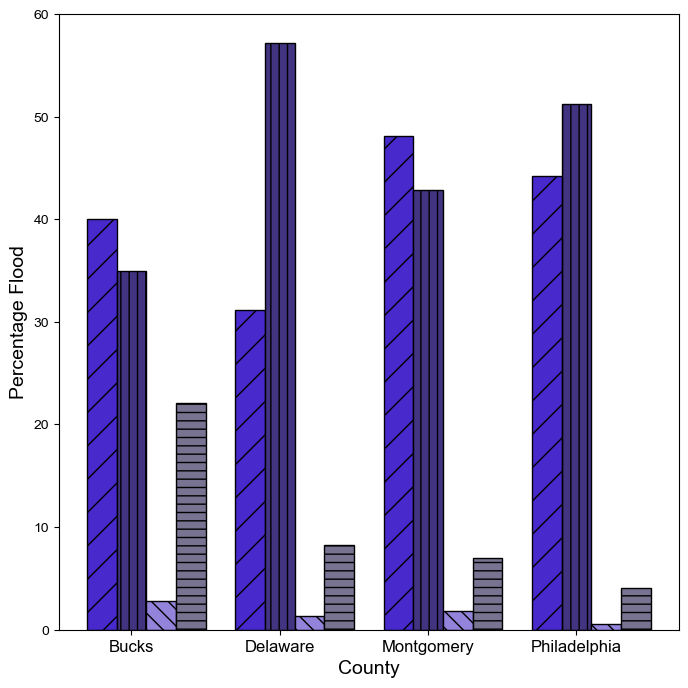

In [26]:
# make bar chart

# set width of bar 
barWidth = 0.2
fig = plt.subplots(figsize =(8, 8)) 

# set height of bar
# fin dataset has the percents
ot = fin['Other']
hun = fin['100-yr']
fiv = fin['500-yr']
min = fin['Minimal Hazard']
 
# Set position of bar on X axis 
br1 = np.arange(len(ot)) 
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 
 
# Make the plot
plt.bar(br1, ot, color ='#4729cc', width = barWidth, hatch='/',
        edgecolor ='black', label ='Other') 
# error bars
#plt.errorbar(br1, ot, yerr=[1,1,1,1], fmt=".k", color="r")
plt.bar(br2, hun, color ='#423481', width = barWidth, hatch='||',
        edgecolor ='black', label ='100-yr') 
plt.bar(br3, fiv, color ='#9383da', width = barWidth, hatch='\\\\',
        edgecolor ='black', label ='500-yr') 
plt.bar(br4, min, color ='#787390', width = barWidth, hatch='--',
        edgecolor ='black', label ='Minimal Hazard') 
 
# Adding Xticks 

plt.xlabel('County', fontsize = 14) 
plt.ylabel('Percentage Flood', fontsize = 14) 
plt.xticks([r + barWidth for r in range(len(hun))], 
        ['Bucks', 'Delaware', 'Montgomery', 'Philadelphia'], fontsize = 12)
#plt.title('Percent Flood in FEMA Zones',fontweight ='bold', fontsize = 18)

#plt.legend(loc='upper left',fontsize=14)
plt.show() 

In [27]:
mid.head()

,COUNTY,area_wat,area_fl,area_c,area_100,area_500,area_min,area_ot,area_100_fz,area_500_fz,...,per_wat,per_fl,per_fl_100,per_fl_500,per_fl_min,per_fl_ot,Flood in Other (km2),Flood in 100-yr (km2),Flood in 500-yr (km2),Flood in Min (km2)
0,Bucks,53.45,6.00,1.733619e+10,1.194661e+09,3.062116e+08,1.538785e+10,4.455301e+08,2.258179e+07,1.823241e+06,...,3.32,0.37,34.97,2.82,22.08,40.01,2.40,2.10,0.17,1.33
1,Delaware,25.25,0.86,5.321207e+09,4.839785e+08,9.698891e+07,4.643968e+09,9.138688e+07,5.270202e+06,1.215294e+05,...,5.11,0.17,57.18,1.32,8.25,31.16,0.27,0.49,0.01,0.07
2,Montgomery,11.96,4.28,1.358125e+10,5.698892e+08,5.136494e+08,1.214186e+10,3.547601e+08,1.972092e+07,8.390117e+05,...,0.95,0.34,42.85,1.82,7.00,48.16,2.06,1.83,0.08,0.30
3,Philadelphia,39.17,1.65,3.978852e+09,4.482764e+08,1.525387e+08,3.288373e+09,8.817740e+07,9.105480e+06,9.016357e+04,...,10.59,0.45,51.22,0.51,4.10,44.18,0.73,0.85,0.01,0.07


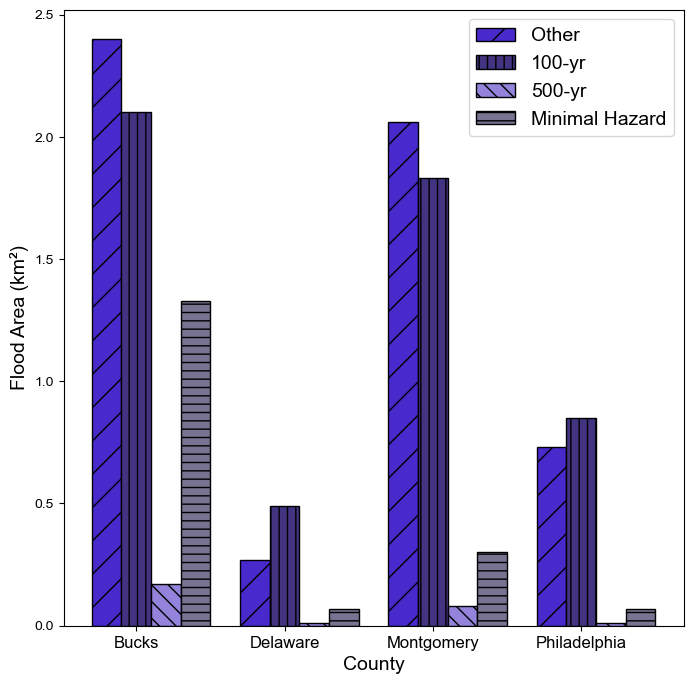

In [28]:
# make bar chart

# set width of bar 
barWidth = 0.2
fig = plt.subplots(figsize =(8, 8)) 

# set height of bar 
ot = mid['Flood in Other (km2)']
hun = mid['Flood in 100-yr (km2)']
fiv = mid['Flood in 500-yr (km2)']
min = mid['Flood in Min (km2)']

# Set position of bar on X axis 
br1 = np.arange(len(ot)) 
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 
 
# Make the plot
plt.bar(br1, ot, color ='#4729cc', width = barWidth, hatch='/',
        edgecolor ='black', label ='Other') 
# error bars
#plt.errorbar(br1, ot, yerr=[1,1,1,1], fmt=".k", color="r")
plt.bar(br2, hun, color ='#423481', width = barWidth, hatch='||',
        edgecolor ='black', label ='100-yr') 
plt.bar(br3, fiv, color ='#9383da', width = barWidth, hatch='\\\\',
        edgecolor ='black', label ='500-yr') 
plt.bar(br4, min, color ='#787390', width = barWidth, hatch='--',
        edgecolor ='black', label ='Minimal Hazard') 

# Adding Xticks 
plt.xlabel('County', fontsize = 14) 
plt.ylabel('Flood Area (km\u00b2)', fontsize = 14) 
plt.xticks([r + barWidth for r in range(len(hun))], 
        ['Bucks', 'Delaware', 'Montgomery', 'Philadelphia'], fontsize = 12)
#plt.title('Flood Area in FEMA Zones',fontweight ='bold', fontsize = 18)

plt.legend(loc='upper right',fontsize=14)
plt.show() 

In [29]:
# Map shows that clip is working 

# Create a map using Stamen Terrain as the basemap
m = folium.Map(location=[40.00,-75.282],        
               titles = 'Flood in 100yr zone',zoom_start = 10)
folium.GeoJson(flo_100,name='Flood in 100yr zone',style_function= lambda x: {'color': 'red'}).add_to(m) # flood in 100yr zones
folium.GeoJson(ex_d2,name='Flood',style_function= lambda x: {'color': 'purple'}).add_to(m) # flood extent
folium.GeoJson(zo_d100,name='100yr flood zone',style_function= lambda x: {'color': 'blue'}).add_to(m) # 100yr zones
folium.LayerControl().add_to(m)
#m

In [30]:
# save as html
#m.save("index.html")

### Step 5: Clip floods to FEMA zones by tract & calculate area

*Summary of Methods*
- Overlay flood extent & tracts, creates new polygons of flood areas w/ tract and tracts w/out flood
- Filter to flooded areas (using if_flood column)
- Clip flooded areas (w/ tract fips) to different FEMA zones
- Get area of all these flood areas per FEMA zone & tract

In [31]:
# prep tracts cont.
tracts_sa = tracts[(tracts['STCNTY']=='42017')|(tracts['STCNTY']=='42045')|(tracts['STCNTY']=='42091')|(tracts['STCNTY']=='42101')]
tracts_sa = tracts_sa[['STCNTY','COUNTY','FIPS','geometry']]
tracts_sa.COUNTY.unique()

array(['Bucks', 'Delaware', 'Montgomery', 'Philadelphia'], dtype=object)

In [32]:
# prep floods data
# filter to flooded areas
test = extent[extent['Class']==2]
tester = test.dissolve('Class')
tester['if_flood'] = 'Y'
tester


,geometry,fid,if_flood
Class,,,
2,"MULTIPOLYGON (((2571928.875 198400.980, 257191...",2.0,Y


In [33]:
# make new polygons of flooding w/tract
# takes > 22 minutes
fl_tract = tester.overlay(tracts_sa, how='union')
fl_tract.head()

c:\Users\rcompos\Anaconda3\envs\NR491\Lib\site-packages\geopandas\geodataframe.py:2451: UserWarning: `keep_geom_type=True` in overlay resulted in 253 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


,fid,if_flood,STCNTY,COUNTY,FIPS,geometry
0,2.0,Y,42017,Bucks,42017100102,"MULTIPOLYGON (((2763332.204 284244.934, 276335..."
1,2.0,Y,42017,Bucks,42017100201,"MULTIPOLYGON (((2749923.548 308176.134, 274992..."
2,2.0,Y,42017,Bucks,42017100207,"MULTIPOLYGON (((2751591.713 299945.600, 275159..."
3,2.0,Y,42017,Bucks,42017100210,"MULTIPOLYGON (((2765056.817 302504.634, 276508..."
4,2.0,Y,42017,Bucks,42017100211,"MULTIPOLYGON (((2761564.171 307172.378, 276156..."


In [34]:
# new tract polygons w/out flooding will have NaN for 'fid' and 'if_flood'
fl_tract.tail()

,fid,if_flood,STCNTY,COUNTY,FIPS,geometry
1262,NaN,NaN,42101,Philadelphia,42101980905,"POLYGON ((2684957.818 214211.086, 2684958.764 ..."
1263,NaN,NaN,42101,Philadelphia,42101980906,"MULTIPOLYGON (((2679338.865 220203.842, 267936..."
1264,NaN,NaN,42101,Philadelphia,42101989100,"MULTIPOLYGON (((2733407.799 266843.286, 273322..."
1265,NaN,NaN,42101,Philadelphia,42101989200,"POLYGON ((2685083.800 214214.731, 2685049.814 ..."
1266,NaN,NaN,42101,Philadelphia,42101989300,"POLYGON ((2702126.397 257864.706, 2702282.658 ..."


In [35]:
# filter to flooded tracts
fl_tract = fl_tract[fl_tract['if_flood']=='Y']
fl_tract.head()

,fid,if_flood,STCNTY,COUNTY,FIPS,geometry
0,2.0,Y,42017,Bucks,42017100102,"MULTIPOLYGON (((2763332.204 284244.934, 276335..."
1,2.0,Y,42017,Bucks,42017100201,"MULTIPOLYGON (((2749923.548 308176.134, 274992..."
2,2.0,Y,42017,Bucks,42017100207,"MULTIPOLYGON (((2751591.713 299945.600, 275159..."
3,2.0,Y,42017,Bucks,42017100210,"MULTIPOLYGON (((2765056.817 302504.634, 276508..."
4,2.0,Y,42017,Bucks,42017100211,"MULTIPOLYGON (((2761564.171 307172.378, 276156..."


In [36]:
len(fl_tract.FIPS.unique())

341

In [37]:
# clip by tract (takes >10min)
# flo_100t = fl_tract.clip(zo_d100t)
# flo_500t = fl_tract.clip(zo_d500t)
# flo_mint = fl_tract.clip(zo_dmint)
# flo_ott = fl_tract.clip(zo_dott)
# #flo_100t

flo_100t = fl_tract.clip(zo_d100)
flo_500t = fl_tract.clip(zo_d500)
flo_mint = fl_tract.clip(zo_dmin)
flo_ott = fl_tract.clip(zo_dot)
#flo_100t

### INTERMISSION - get flood zone percent per tract

In [38]:
#tracts_sa
#zo_d100.head()
flo_100t

,fid,if_flood,STCNTY,COUNTY,FIPS,geometry
118,2.0,Y,42045,Delaware,42045406600,"MULTIPOLYGON (((2627537.253 184005.956, 262758..."
117,2.0,Y,42045,Delaware,42045406500,"MULTIPOLYGON (((2630385.880 186995.293, 263039..."
146,2.0,Y,42045,Delaware,42045410700,"MULTIPOLYGON (((2643540.392 197072.533, 264356..."
112,2.0,Y,42045,Delaware,42045404300,"MULTIPOLYGON (((2650014.100 200228.690, 265008..."
140,2.0,Y,42045,Delaware,42045410200,"MULTIPOLYGON (((2577709.599 192093.818, 257770..."
...,...,...,...,...,...,...
58,2.0,Y,42017,Bucks,42017104506,"POLYGON ((2713631.909 383206.011, 2713656.934 ..."
51,2.0,Y,42017,Bucks,42017104301,"MULTIPOLYGON (((2736977.059 402427.260, 273700..."
48,2.0,Y,42017,Bucks,42017104201,"MULTIPOLYGON (((2718711.595 405525.702, 271866..."
46,2.0,Y,42017,Bucks,42017103900,"MULTIPOLYGON (((2716296.850 408398.768, 271629..."


In [40]:
a = tracts_sa.clip(zo_d100)
b = tracts_sa.clip(zo_d500)
c = tracts_sa.clip(zo_dmin)
d = tracts_sa.clip(zo_dot)

KeyboardInterrupt: 

In [ ]:
# add area col
a['area_100'] = a.area
b['area_500'] = b.area
c['area_min'] = c.area
d['area_ot'] = d.area

a=a[['FIPS','area_100']]
b=b[['FIPS','area_500']]
c=c[['FIPS','area_min']]
d=d[['FIPS','area_ot']]

# merge
zone_area = a.merge(b,on='FIPS',how='outer').merge(c,on='FIPS',how='outer').merge(d,on='FIPS',how='outer')
zone_area.head()

,FIPS,area_100,area_500,area_min,area_ot
0,42045406600,1.810756e+07,4.748649e+06,2.201853e+07,3.467579e+05
1,42045406700,3.949566e+05,6.378638e+04,2.955328e+07,3.264599e+05
2,42045406500,1.443687e+07,1.769918e+06,2.115614e+07,9.014080e+05
3,42045406804,1.207824e+06,3.971623e+05,3.074115e+07,9.877996e+05
4,42045406802,1.453032e+06,5.044559e+05,5.130198e+07,1.002734e+06


In [ ]:
zone_a = tracts_sa.merge(zone_area,on='FIPS',how='left')
zone_a.fillna(0,inplace=True)
zone_a.drop(columns=['STCNTY','geometry','COUNTY'],inplace=True)

C:\Users\rcompos\AppData\Local\Temp\ipykernel_25428\3904340133.py:2: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the interim, the keyword is ignored by GeometryArray.
  zone_a.fillna(0,inplace=True)


In [ ]:
zone_a.to_csv('data\\zones_area.csv',index=False)

### Back to regularly scheduled programming

In [42]:
# calculate area of flood in different zones
flo_100t['area_100_fzt'] = flo_100t.area
flo_500t['area_500_fzt'] = flo_500t.area
flo_mint['area_min_fzt'] = flo_mint.area
flo_ott['area_ot_fzt'] = flo_ott.area
flo_100t.head()

,fid,if_flood,STCNTY,COUNTY,FIPS,geometry,area_100_fzt
118,2.0,Y,42045,Delaware,42045406600,"MULTIPOLYGON (((2627537.253 184005.956, 262758...",1.828420e+05
117,2.0,Y,42045,Delaware,42045406500,"MULTIPOLYGON (((2630385.880 186995.293, 263039...",7.928239e+04
146,2.0,Y,42045,Delaware,42045410700,"MULTIPOLYGON (((2643540.392 197072.533, 264356...",5.152682e+05
112,2.0,Y,42045,Delaware,42045404300,"MULTIPOLYGON (((2650014.100 200228.690, 265008...",3.316715e+05
140,2.0,Y,42045,Delaware,42045410200,"MULTIPOLYGON (((2577709.599 192093.818, 257770...",2.020147e+06


In [43]:
# merge dataframes
d1t = flo_100t[['FIPS','area_100_fzt']]
d2t = flo_500t[['FIPS','area_500_fzt']]
d3t = flo_mint[['FIPS','area_min_fzt']]
d4t = flo_ott[['FIPS','area_ot_fzt']]
flood_table_tract = d1t.merge(d2t,on='FIPS',how='outer').merge(d3t,on='FIPS',how='outer').merge(d4t,on='FIPS',how='outer')
#len(flood_table_tract.FIPS.unique())
flood_table_tract_g = flood_table_tract.groupby('FIPS').sum().reset_index()
flood_table_tract_g

,FIPS,area_100_fzt,area_500_fzt,area_min_fzt,area_ot_fzt
0,42017100102,675041.575941,0.000000,4935.851208,106259.189566
1,42017100201,121255.013608,0.000000,0.000000,182132.088508
2,42017100207,0.000000,0.000000,4110.485603,0.000000
3,42017100210,105346.805343,0.000000,0.000000,288498.005689
4,42017100211,126157.205234,64.548459,0.000000,544173.612307
...,...,...,...,...,...
335,42101980904,348094.534584,11.132576,58536.538118,690491.449835
336,42101980905,166941.023463,0.000000,0.000000,97213.807542
337,42101980906,279934.058068,0.000000,235918.080640,658141.090956
338,42101989100,207924.970716,9479.396069,1221.668568,27300.791804


In [44]:
# calculate total area flooded per tract
fl_tract['area_fl_tra'] = fl_tract.area

# some flooded areas not in tracts, so remove
fl_tract.dropna(subset=['STCNTY'],inplace=True)

# group by fips code
fl_tra = fl_tract[['FIPS','area_fl_tra']]
fl_per_tract_g = fl_tra.groupby('FIPS').sum().reset_index()
fl_per_tract_g #378 rows

,FIPS,area_fl_tra
0,42017100102,7.862369e+05
1,42017100201,3.033871e+05
2,42017100207,4.110486e+03
3,42017100210,3.938448e+05
4,42017100211,6.703954e+05
...,...,...
335,42101980904,1.097134e+06
336,42101980905,2.641548e+05
337,42101980906,1.173993e+06
338,42101989100,2.459268e+05


In [45]:
# merge flood area with tract geometry
fl_p_t = flood_table_tract_g.merge(fl_per_tract_g,on='FIPS')
fl_p_t


,FIPS,area_100_fzt,area_500_fzt,area_min_fzt,area_ot_fzt,area_fl_tra
0,42017100102,675041.575941,0.000000,4935.851208,106259.189566,7.862369e+05
1,42017100201,121255.013608,0.000000,0.000000,182132.088508,3.033871e+05
2,42017100207,0.000000,0.000000,4110.485603,0.000000,4.110486e+03
3,42017100210,105346.805343,0.000000,0.000000,288498.005689,3.938448e+05
4,42017100211,126157.205234,64.548459,0.000000,544173.612307,6.703954e+05
...,...,...,...,...,...,...
335,42101980904,348094.534584,11.132576,58536.538118,690491.449835,1.097134e+06
336,42101980905,166941.023463,0.000000,0.000000,97213.807542,2.641548e+05
337,42101980906,279934.058068,0.000000,235918.080640,658141.090956,1.173993e+06
338,42101989100,207924.970716,9479.396069,1221.668568,27300.791804,2.459268e+05


In [46]:
# convert to km
fl_p_t['area_100_km'] = fl_p_t['area_100_fzt'].divide(1.076e+7).round(3)
fl_p_t['area_500_km'] = fl_p_t['area_500_fzt'].divide(1.076e+7).round(3)
fl_p_t['area_min_km'] = fl_p_t['area_min_fzt'].divide(1.076e+7).round(3)
fl_p_t['area_ot_km'] = fl_p_t['area_ot_fzt'].divide(1.076e+7).round(3)
fl_p_t['area_fl_km'] = fl_p_t['area_fl_tra'].divide(1.076e+7).round(3)

# add percent flooding columns
fl_p_t['per_fl_100'] = ((fl_p_t['area_100_fzt'].div(fl_p_t['area_fl_tra']))*100).round(2)
fl_p_t['per_fl_500'] = ((fl_p_t['area_500_fzt'].div(fl_p_t['area_fl_tra']))*100).round(2)
fl_p_t['per_fl_min'] = ((fl_p_t['area_min_fzt'].div(fl_p_t['area_fl_tra']))*100).round(2)
fl_p_t['per_fl_ot'] = ((fl_p_t['area_ot_fzt'].div(fl_p_t['area_fl_tra']))*100).round(2)

fl_p_t.head()

,FIPS,area_100_fzt,area_500_fzt,area_min_fzt,area_ot_fzt,area_fl_tra,area_100_km,area_500_km,area_min_km,area_ot_km,area_fl_km,per_fl_100,per_fl_500,per_fl_min,per_fl_ot
0,42017100102,675041.575941,0.000000,4935.851208,106259.189566,786236.908566,0.063,0.0,0.0,0.010,0.073,85.86,0.00,0.63,13.51
1,42017100201,121255.013608,0.000000,0.000000,182132.088508,303387.102116,0.011,0.0,0.0,0.017,0.028,39.97,0.00,0.00,60.03
2,42017100207,0.000000,0.000000,4110.485603,0.000000,4110.485603,0.000,0.0,0.0,0.000,0.000,0.00,0.00,100.00,0.00
3,42017100210,105346.805343,0.000000,0.000000,288498.005689,393844.811032,0.010,0.0,0.0,0.027,0.037,26.75,0.00,0.00,73.25
4,42017100211,126157.205234,64.548459,0.000000,544173.612307,670395.365999,0.012,0.0,0.0,0.051,0.062,18.82,0.01,0.00,81.17


In [47]:
# add tract area to table
tracts_sa['area_tract'] = tracts_sa.area

# merge
fl_p_tt = fl_p_t.merge(tracts_sa,on='FIPS')
fl_p_tt['per_fl_tra'] = ((fl_p_tt['area_fl_tra'].div(fl_p_tt['area_tract']))*100).round(2)
fl_p_tt

# convert area from ft to km^2
#fl_p_t['area_fl_tra'] = fl_p_t['area_fl_tra'].divide(1.076e+7).round(2)


,FIPS,area_100_fzt,area_500_fzt,area_min_fzt,area_ot_fzt,area_fl_tra,area_100_km,area_500_km,area_min_km,area_ot_km,area_fl_km,per_fl_100,per_fl_500,per_fl_min,per_fl_ot,STCNTY,COUNTY,geometry,area_tract,per_fl_tra
0,42017100102,675041.575941,0.000000,4935.851208,106259.189566,7.862369e+05,0.063,0.000,0.000,0.010,0.073,85.86,0.00,0.63,13.51,42017,Bucks,"MULTIPOLYGON (((2742575.253 275325.003, 274355...",1.093372e+08,0.72
1,42017100201,121255.013608,0.000000,0.000000,182132.088508,3.033871e+05,0.011,0.000,0.000,0.017,0.028,39.97,0.00,0.00,60.03,42017,Bucks,"MULTIPOLYGON (((2739489.834 302502.205, 273910...",7.068223e+07,0.43
2,42017100207,0.000000,0.000000,4110.485603,0.000000,4.110486e+03,0.000,0.000,0.000,0.000,0.000,0.00,0.00,100.00,0.00,42017,Bucks,"MULTIPOLYGON (((2746406.635 302892.674, 274686...",5.570794e+07,0.01
3,42017100210,105346.805343,0.000000,0.000000,288498.005689,3.938448e+05,0.010,0.000,0.000,0.027,0.037,26.75,0.00,0.00,73.25,42017,Bucks,"MULTIPOLYGON (((2755566.713 295620.537, 275741...",7.169043e+07,0.55
4,42017100211,126157.205234,64.548459,0.000000,544173.612307,6.703954e+05,0.012,0.000,0.000,0.051,0.062,18.82,0.01,0.00,81.17,42017,Bucks,"MULTIPOLYGON (((2750074.964 308365.492, 275093...",3.227411e+07,2.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,42101980904,348094.534584,11.132576,58536.538118,690491.449835,1.097134e+06,0.032,0.000,0.005,0.064,0.102,31.73,0.00,5.34,62.94,42101,Philadelphia,"MULTIPOLYGON (((2680406.890 227052.348, 268142...",1.854181e+07,5.92
336,42101980905,166941.023463,0.000000,0.000000,97213.807542,2.641548e+05,0.016,0.000,0.000,0.009,0.025,63.20,0.00,0.00,36.80,42101,Philadelphia,"MULTIPOLYGON (((2680586.350 215843.175, 268548...",1.162602e+07,2.27
337,42101980906,279934.058068,0.000000,235918.080640,658141.090956,1.173993e+06,0.026,0.000,0.022,0.061,0.109,23.84,0.00,20.10,56.06,42101,Philadelphia,"MULTIPOLYGON (((2679238.973 220137.584, 267967...",3.588442e+07,3.27
338,42101989100,207924.970716,9479.396069,1221.668568,27300.791804,2.459268e+05,0.019,0.001,0.000,0.003,0.023,84.55,3.85,0.50,11.10,42101,Philadelphia,"MULTIPOLYGON (((2732166.964 265883.217, 273340...",4.605841e+07,0.53


In [48]:
# convert to csv
flood_tr_path = 'data\\flood_per_tract624.csv'
fl_p_tt.to_csv(flood_tr_path,index=False)


### Step 6: Make tract figures

In [49]:
# export geojson for plotting
for_plot = tracts_sa.merge(fl_p_tt[['FIPS','per_fl_tra','per_fl_100','per_fl_500','per_fl_min','per_fl_ot',
                                    'area_fl_km','area_100_km','area_500_km','area_min_km']],on='FIPS')
#for_plot.to_file('FEMA_outputs\per_area_fl_tra2.geojson', driver='GeoJSON')

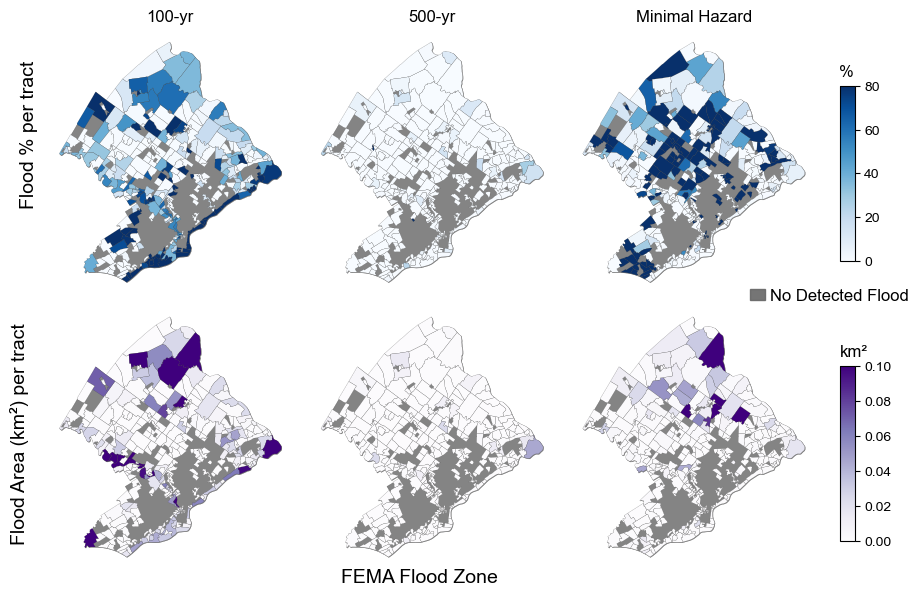

In [50]:
col_names = ['per_fl_100','per_fl_500','per_fl_min',
              'area_100_km','area_500_km','area_min_km']

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

#fig.suptitle("Percent and Area (km\u00b2) of Floods in Tract and FEMA Zones", fontsize=14, y=0.95,weight='bold')

# hspace = height, bottom, wspace = width, left, right
plt.subplots_adjust(wspace = 0.04,hspace=0.04)
#plt.margins(0.8) 

# label y axis
# (x --> bigger is further from plots on the right) (x, y)
fig.text(0.1, .73, 'Flood % per tract', va='center', rotation='vertical', fontsize=14)
fig.text(0.1, .15, 'Flood Area (km\u00b2) per tract', ha='center', rotation='vertical', fontsize=14)

# label x axis
#fig.text(0.25, 0.09, '100-yr', ha='center', fontsize=12)
#fig.text(0.5, 0.09, '500-yr', ha='center', fontsize=12)
#fig.text(0.75, 0.09, 'Minimal Hazard', ha='center', fontsize=12)
fig.text(0.5, 0.09, 'FEMA Flood Zone', ha='center', fontsize=14)

# Get min and max values for consistent colors
common_vmin = for_plot['per_fl_tra'].min()
common_vmax = for_plot['per_fl_tra'].max()
common_vmin_a = for_plot['area_100_km'].min()
common_vmax_a = for_plot['area_100_km'].max()

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Loop through the columns and plot each one in a separate subplot
for i, column in enumerate(col_names[:8]):
    if column in ['per_fl_100','per_fl_500','per_fl_min']:
        #plot the percent per tract
        sa.plot(ax=axes[i], color='#666666',alpha=0.8,linewidth=0.2, edgecolor="#333333")
        for_plot.plot(column=column, ax=axes[i], legend=False, cmap="Blues", vmin=common_vmin, vmax=80,linewidth=0.1, edgecolor="#333333")
        titles = ['100-yr','500-yr','Minimal Hazard']
        axes[i].set_title(titles[i])
        axes[i].axis("off")  # Turn off the axis border 
    else:
        # plot the area per tract
        sa.plot(ax=axes[i], color='#666666',alpha=0.8,linewidth=0.2, edgecolor="#333333")
        for_plot.plot(column=column, ax=axes[i], legend=False, cmap="Purples",vmin=common_vmin_a, vmax=.1,linewidth=0.1, edgecolor="#333333")
        axes[i].axis("off")  # Turn off the axis border 

# Legend for nodata
fig.patches.extend([plt.Rectangle((0.83,0.495),0.015,0.015, # (x,y) width, height
                                  fill=True, color='#666666', alpha=.9, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
fig.text(0.85, .5, 'No Detected Flood', va='center', fontsize=12)

# Legend for percents
cax = fig.add_axes([0.92, 0.55, 0.015, 0.25])  # southwest corner, width, height
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=common_vmin, vmax=80))
sm._A = []
fig.colorbar(sm, cax=cax)
fig.text(0.92, .82, '%', va='center', fontsize=12)

# Legend for area
caxa = fig.add_axes([0.92, 0.15, 0.015, 0.25])  # southwest corner, width, height .15+.25/2 = 
sma = plt.cm.ScalarMappable(cmap="Purples", norm=plt.Normalize(vmin=common_vmin_a, vmax=.1))
sma._A = []
fig.colorbar(sma, cax=caxa)
fig.text(0.92, .42, 'km\u00b2', va='center', fontsize=12)

# Adjust layout to prevent clipping of subplot titles
#plt.tight_layout()

# Show the plots
#plt.savefig("floo_v1.pdf", format="pdf", bbox_inches="tight")
plt.show()

(array([164.,  22.,  19.,  23.,  15.,  14.,  12.,  20.,   7.,  44.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

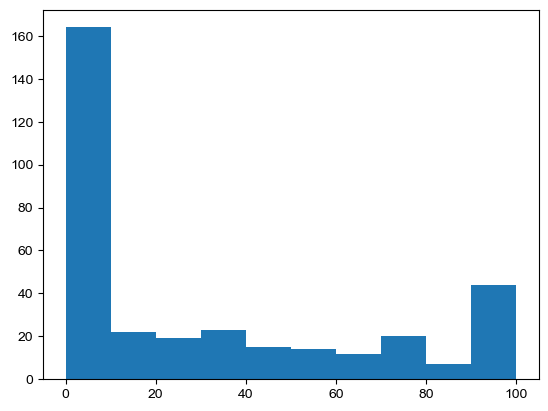

In [51]:
# quick histogram of percent values
plt.hist(for_plot['per_fl_100'].values)